# NLP: Clasification in SPAM or NO SPAM

In [1]:
import time

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  print(f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.')

In [3]:
start = time.time()

# Code execution

### 1. Import libraries

In [4]:
import re
import nltk
import math
import torch
import torchtext
import numpy as np
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import torch.nn as nn
nltk.download('stopwords')
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from nltk.corpus import stopwords
from torchtext import data, datasets
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, TensorDataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Import embedding

In [6]:
import gensim.downloader

In [7]:
%%time

glove_vectors = gensim.downloader.load('word2vec-google-news-300')

CPU times: user 54.2 s, sys: 3.06 s, total: 57.3 s
Wall time: 1min 5s


### 3. Read data

In [8]:
path = 'drive/MyDrive/Ayudantia DL (Rol Ayudante)/SMSSpamCollection'

In [9]:
with open(path) as file:
  data = file.readlines()

In [10]:
data = [i.split('\t') for i in data]

In [11]:
all_txt = [i[1] for i in data]
label = [i[0] for i in data]

In [12]:
df = pd.DataFrame({'txt': all_txt, 'class': label})

In [13]:
df = df.replace({'class': {'spam': 1, 'ham': 0}})

### i. Explore the label

In [14]:
df['class'].value_counts()

0    4827
1     747
Name: class, dtype: int64

In [15]:
round(df['class'].value_counts(normalize = True)*100, 2)

0    86.6
1    13.4
Name: class, dtype: float64

### 4. Clean the texts

### i. Remove special characters

In [16]:
signs = []

for i in range(len(data)):

  txt_part = df['txt'].iloc[i]

  for c in txt_part:

    if c.isalpha() == True or c.isdigit() == True:
      pass

    else:

      if (c in signs) == False:
        signs.append(c)

signs.remove(' ')

In [17]:
len(signs)

46

In [18]:
def remove_signs(txt, signs):

  new_txt = ''

  for c in txt:

    if c in signs:
      pass

    else:
      new_txt = new_txt + c

  return new_txt

In [19]:
df['txt'] = df['txt'].map(lambda x: remove_signs(x, signs))

### ii. All the word to lower case

In [20]:
df['txt'] = df['txt'].map(lambda x: x.lower())

### iii. Separate X and y

In [21]:
X = df[['txt']].copy()
y = df['class'].copy()

### 5. Split

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

### i. Explore the split

**a. Train**

In [25]:
X_train.shape

(3344, 1)

In [26]:
round(y_train.mean()*100, 2)

13.37

In [27]:
y_train.value_counts()

0    2897
1     447
Name: class, dtype: int64

**b. Val**

In [28]:
X_val.shape

(1115, 1)

In [29]:
round(y_val.mean()*100, 2)

13.0

In [30]:
y_val.value_counts()

0    970
1    145
Name: class, dtype: int64

**c. Test**

In [31]:
X_test.shape

(1115, 1)

In [32]:
round(y_test.mean()*100, 2)

13.9

In [33]:
y_test.value_counts()

0    960
1    155
Name: class, dtype: int64

### 6. OverSampling

In [34]:
from imblearn.over_sampling import RandomOverSampler

In [35]:
oversample = RandomOverSampler(random_state = 0)

In [36]:
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [37]:
round(y_train_os.mean()*100, 2)

50.0

In [38]:
y_train_os.value_counts()

1    2897
0    2897
Name: class, dtype: int64

### 7. Lenght

In [39]:
len_X_train = X_train['txt'].map(lambda x: len(x.split(' ')))

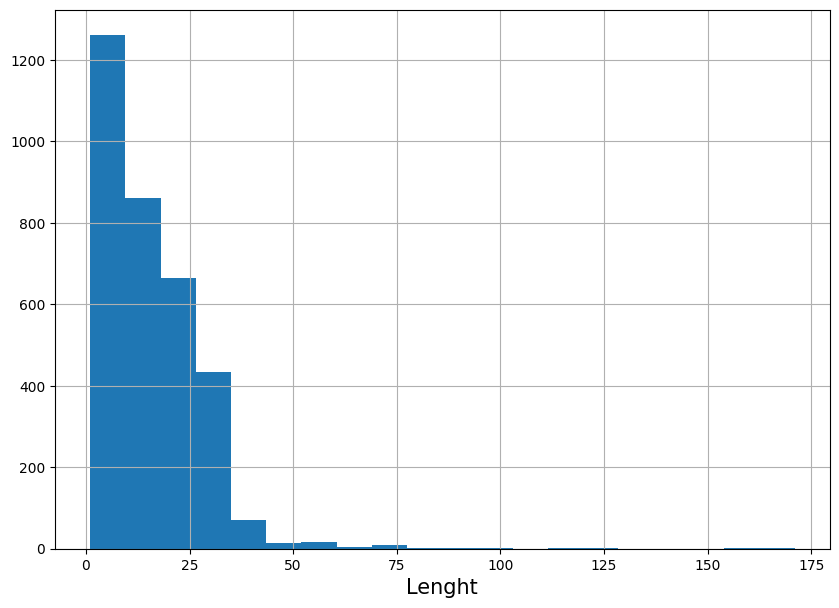

In [40]:
plt.figure(figsize = (10, 7))
len_X_train.hist(bins = 20)
plt.xlabel('Lenght', fontsize = 15)
plt.show()

In [41]:
len_X_train.describe()

count    3344.000000
mean       15.890849
std        11.932520
min         1.000000
25%         7.000000
50%        12.500000
75%        23.000000
max       171.000000
Name: txt, dtype: float64

In [42]:
round(((len_X_train <= 20).sum()/len(len_X_train))*100, 2)

69.71

In [43]:
round(((len_X_train <= 25).sum()/len(len_X_train))*100, 2)

80.47

In [44]:
round(((len_X_train <= 30).sum()/len(len_X_train))*100, 2)

92.31

In [45]:
round(((len_X_train <= 35).sum()/len(len_X_train))*100, 2)

96.77

In [46]:
round(((len_X_train <= 40).sum()/len(len_X_train))*100, 2)

98.0

### 8. Tokenization

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
def txt_to_vec(text, max_len, embedding):

  vec_txt = []

  split_text = text.split(' ')
  split_text = split_text[0: max_len]

  for i in range(max_len):

    try:
      s_t = split_text[i]
      vec_txt.append(embedding[s_t])

    except:
      vec_txt.append(np.zeros(300))

  return vec_txt

In [49]:
def word_2_vec(input_X, input_y, embedding, n_batches, max_len):

  output_X = []
  output_y = []

  h_batches = int(len(input_X)/n_batches) + 1

  for n_batch in range(n_batches):

    input_X_batch = input_X.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]
    input_y_batch = input_y.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]

    out_X = []
    out_y = []

    for i in range(len(input_X_batch)):

      txt_part = input_X_batch['txt'].iloc[i]
      class_part = input_y_batch.iloc[i]

      out_X.append(txt_to_vec(txt_part, max_len, embedding))

      if class_part == 1:

        out_y.append([1, 0])

      else:

        out_y.append([0, 1])

    output_X.append(torch.Tensor(out_X))
    output_y.append(torch.Tensor(out_y))

  return output_X, output_y

In [50]:
max_length = 40
n_batches_train = 4

In [51]:
X_train_c, y_train_c = word_2_vec(X_train, y_train, glove_vectors, n_batches_train, max_length)

In [52]:
X_train_os_c, y_train_os_c = word_2_vec(X_train_os, y_train_os, glove_vectors, n_batches_train, max_length)

In [53]:
X_val_c, y_val_c = word_2_vec(X_val, y_val, glove_vectors, 1, max_length)

In [54]:
X_test_c, y_test_c = word_2_vec(X_test, y_test, glove_vectors, 1, max_length)

### 9. Creation class NN

In [55]:
class RNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)

        out, h = self.rnn(x, h)

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [56]:
class GRU(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)

        out, h = self.gru(x, h)

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [57]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        out, (h, c) = self.lstm(x, (h,c))

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [58]:
class LSTM_BI(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(LSTM_BI, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional = True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words*2, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        out, (h, c) = self.lstm(x, (h,c))

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(2*self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

### 10. Connection to GPU

In [59]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### 11. Sets to GPU

In [60]:
for i in range(n_batches_train):

  # Train

  X_train_c[i] = X_train_c[i].to(device)
  y_train_c[i] = y_train_c[i].to(device)

  # Train: Oversampling

  X_train_os_c[i] = X_train_os_c[i].to(device)
  y_train_os_c[i] = y_train_os_c[i].to(device)

# Validation

X_val_c[0] = X_val_c[0].to(device)
y_val_c[0] = y_val_c[0].to(device)

# Test

X_test_c[0] = X_test_c[0].to(device)
y_test_c[0] = y_test_c[0].to(device)

### 12. Creation class model_NLP

In [61]:
from sklearn.metrics import recall_score

In [62]:
class model_NLP:

  def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, lr, n_epochs, n_batches, device, class_model):

    self.input_size = input_size
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.len_words = len_words
    self.lr = lr
    self.n_epochs = n_epochs
    self.n_batches = n_batches

    self.device = device

    self.model = class_model(self.input_size, self.output_size, self.hidden_dim, self.n_layers, self.len_words, self.device)

    self.model = self.model.to(device)


  def evaluate(self, X):

    self.model.train()

    out_eval = self.model(X)
    out_eval = out_eval.cpu().detach().numpy()
    out_eval = np.exp(out_eval)[:, 0]

    return out_eval


  def train(self, X_train_set, y_train_set, X_val_set, y_val_set, verbose = True, graph = True):

    # Define criterion and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)

    start_train = time.time()

    #----------------------------------------------------------------------

    all_loss_train = []
    all_loss_val = []

    all_recall_train = []
    all_recall_val = []

    all_epochs = []

    for epoch in range(1, self.n_epochs + 1):

      #--------------------------------------------------------------------

      start_epoch = time.time()

      #--------------------------------------------------------------------

      # 1. Train epoch

      self.model.train()

      loss_train_epoch = 0
      recall_train_epoch = 0

      for n in range(self.n_batches):

        X_batch = X_train_set[n]
        y_batch = y_train_set[n]

        optimizer.zero_grad() # Clears existing gradients

        out_train_batch = self.model(X_batch)
        loss_train_batch = criterion(out_train_batch, y_batch)

        loss_train_batch.backward()
        optimizer.step() # Updates the weights accordingly

        loss_train_epoch = loss_train_epoch + loss_train_batch.item()/len(X_batch)

        #--------------------------------------------------------------------

        recall_train_batch = recall_score(
            y_batch[:, 0].cpu().detach().numpy(),
            (np.exp(out_train_batch.cpu().detach().numpy())[:, 0] > 0.5)*1,
            average = 'macro'
            )

        recall_train_epoch = recall_train_epoch + recall_train_batch

        #--------------------------------------------------------------------

      #--------------------------------------------------------------------

      loss_train_epoch = loss_train_epoch/self.n_batches

      all_loss_train.append(loss_train_epoch)
      all_epochs.append(epoch)

      recall_train_epoch = recall_train_epoch/self.n_batches
      recall_train_epoch = round(recall_train_epoch*100, 2)

      all_recall_train.append(recall_train_epoch)

      #--------------------------------------------------------------------

      # 2. Evaluate in validation set

      self.model.eval()

      out_val = self.model(X_val_set[0])
      loss_val = criterion(out_val, y_val_set[0])
      loss_val = loss_val.item()/len(X_val_set[0])

      all_loss_val.append(loss_val)

      recall_val = recall_score(
          y_val_set[0][:, 0].cpu().detach().numpy(),
          (np.exp(out_val.cpu().detach().numpy())[:, 0] > 0.5)*1,
          average = 'macro'
      )

      recall_val = round(recall_val*100, 2)
      all_recall_val.append(recall_val)

      #--------------------------------------------------------------------

      end_epoch = time.time()

      #--------------------------------------------------------------------

      if verbose:

        print('Epoch:', epoch)

        print('\n')

        print('Loss Train:', loss_train_epoch)

        print('Loss Val:', loss_val)

        print('\n')

        print('Recall Train:', recall_train_epoch)

        print('Recall Val:', recall_val)

        print('\n')

        print_time_execution(start_epoch, end_epoch, f'Run the epoch.')

        print('\n')

        print('-'*70)

      #--------------------------------------------------------------------

    #--------------------------------------------------------------------

    end_train = time.time()

    print_time_execution(start_train, end_train, f'In training the model')

    print('\n')

    print('-'*70)

    print('\n')

    #--------------------------------------------------------------------

    if graph:

      # i. Loss

      plt.figure(figsize = (10, 7))

      plt.plot(all_epochs, all_loss_train, label = 'Loss Train', color = 'blue')
      plt.plot(all_epochs, all_loss_val, label = 'Loss val', color = 'red')

      plt.title('Loss', fontsize = 17)

      plt.xlabel('Number of epochs', fontsize = 15)
      plt.ylabel('Loss', fontsize = 15)

      plt.legend()

      plt.show()

      print('\n')

      print('\n')

      # ii. Recall

      plt.figure(figsize = (10, 7))

      plt.plot(all_epochs, all_recall_train, label = 'Recall Train', color = 'blue')
      plt.plot(all_epochs, all_recall_val, label = 'Recall val', color = 'red')

      plt.title('Recall', fontsize = 17)

      plt.xlabel('Number of epochs', fontsize = 15)
      plt.ylabel('Recall', fontsize = 15)

      plt.legend()

      plt.show()

    #--------------------------------------------------------------------

# 13. Hyperparameter Tuning

In [63]:
all_hidden_dim = [(10*i + 70) for i in range(3)]
all_n_layers = [1, 2]
all_lr = [0.001*i for i in range(1, 2 + 1)]
all_n_epochs = [10*i for i in range(2, 4 + 1)]

### i. RNN

In [64]:
class_model = RNN
start_rnn = time.time()

In [65]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_length, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.5)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)



Hyperparameters:


Hidden dim: 70
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 1 segs.


----------------------------------------------------------------------


Recall val: 87.59


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 80
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------


Recall val: 89.66


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 90
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins 

In [66]:
print('Optimal recall:', all_recall_val[all_recall_val == all_recall_val.max()][0])
print('Hidden dim (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][0]))
print('N layers (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][1]))
print('LR (Opt):', all_params[all_recall_val == all_recall_val.max()][0][2])
print('N epochs (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][3]))

Optimal recall: 93.1
Hidden dim (Opt): 70
N layers (Opt): 2
LR (Opt): 0.002
N epochs (Opt): 40


In [67]:
end_rnn = time.time()
print_time_execution(start_rnn, end_rnn, f'Tuning the RNN')

Tuning the RNN it takes 0 hours, 0 mins and 36 segs.


### ii. GRU

In [68]:
class_model = GRU
start_gru = time.time()

In [69]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_length, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.5)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)



Hyperparameters:


Hidden dim: 70
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------


Recall val: 86.21


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 80
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------


Recall val: 87.59


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 90
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins 

In [70]:
print('Optimal recall:', all_recall_val[all_recall_val == all_recall_val.max()][0])
print('Hidden dim (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][0]))
print('N layers (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][1]))
print('LR (Opt):', all_params[all_recall_val == all_recall_val.max()][0][2])
print('N epochs (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][3]))

Optimal recall: 95.17
Hidden dim (Opt): 70
N layers (Opt): 1
LR (Opt): 0.002
N epochs (Opt): 30


In [71]:
end_gru = time.time()
print_time_execution(start_gru, end_gru, f'Tuning the GRU')

Tuning the GRU it takes 0 hours, 1 mins and 8 segs.


### iii. LSTM

In [72]:
class_model = LSTM
start_lstm = time.time()

In [73]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_length, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.5)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)



Hyperparameters:


Hidden dim: 70
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 1 segs.


----------------------------------------------------------------------


Recall val: 86.9


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 80
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 1 segs.


----------------------------------------------------------------------


Recall val: 88.28


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 90
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins a

In [74]:
print('Optimal recall:', all_recall_val[all_recall_val == all_recall_val.max()][0])
print('Hidden dim (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][0]))
print('N layers (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][1]))
print('LR (Opt):', all_params[all_recall_val == all_recall_val.max()][0][2])
print('N epochs (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][3]))

Optimal recall: 94.48
Hidden dim (Opt): 70
N layers (Opt): 2
LR (Opt): 0.001
N epochs (Opt): 40


In [75]:
end_lstm = time.time()
print_time_execution(start_lstm, end_lstm, f'Tuning the LSTM')

Tuning the LSTM it takes 0 hours, 1 mins and 18 segs.


### iv. LSTM BI

In [76]:
class_model = LSTM_BI
start_lstm_bi = time.time()

In [77]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_length, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.5)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)



Hyperparameters:


Hidden dim: 70
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 1 segs.


----------------------------------------------------------------------


Recall val: 86.21


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 80
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins and 2 segs.


----------------------------------------------------------------------


Recall val: 84.14


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 90
N layers: 1
LR: 0.001
N epochs: 20


In training the model it takes 0 hours, 0 mins 

In [78]:
print('Optimal recall:', all_recall_val[all_recall_val == all_recall_val.max()][0])
print('Hidden dim (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][0]))
print('N layers (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][1]))
print('LR (Opt):', all_params[all_recall_val == all_recall_val.max()][0][2])
print('N epochs (Opt):', int(all_params[all_recall_val == all_recall_val.max()][0][3]))

Optimal recall: 93.79
Hidden dim (Opt): 80
N layers (Opt): 2
LR (Opt): 0.001
N epochs (Opt): 30


In [79]:
end_lstm_bi = time.time()
print_time_execution(start_lstm_bi, end_lstm_bi, f'Tuning the LSTM_BI')

Tuning the LSTM_BI it takes 0 hours, 2 mins and 38 segs.


# 14. Testing and Calibration

### i. Train the optimal model

In [80]:
hidden_dim_opt = 80
n_layers_opt = 1
lr_opt = 0.002
n_epochs_opt = 30

class_model_opt = GRU

Epoch: 1


Loss Train: 0.0005817897002670979
Loss Val: 0.00035133439329173


Recall Train: 49.75
Recall Val: 50.0


Run the epoch. it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------
Epoch: 2


Loss Train: 0.00041432802468161574
Loss Val: 0.0002764192129998998


Recall Train: 50.21
Recall Val: 59.64


Run the epoch. it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------
Epoch: 3


Loss Train: 0.0003284519186435147
Loss Val: 0.00019289605286089295


Recall Train: 67.01
Recall Val: 64.14


Run the epoch. it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------
Epoch: 4


Loss Train: 0.0002293380215301102
Loss Val: 0.0001335205785896746


Recall Train: 67.9
Recall Val: 79.35


Run the epoch. it takes 0 hours, 0 mins and 0 segs.


----------------------------------------------------------------------
Epoch: 5


Loss Train: 0.0

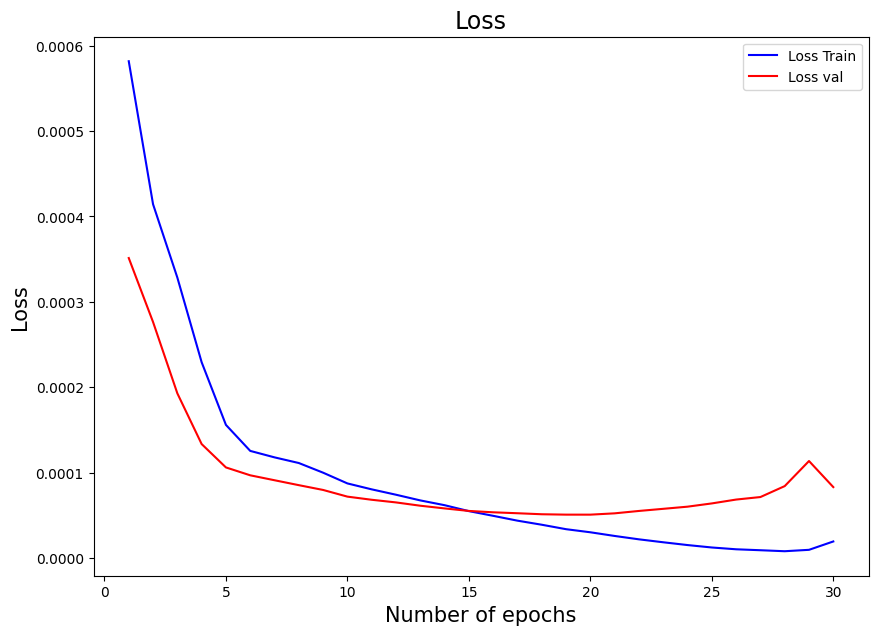

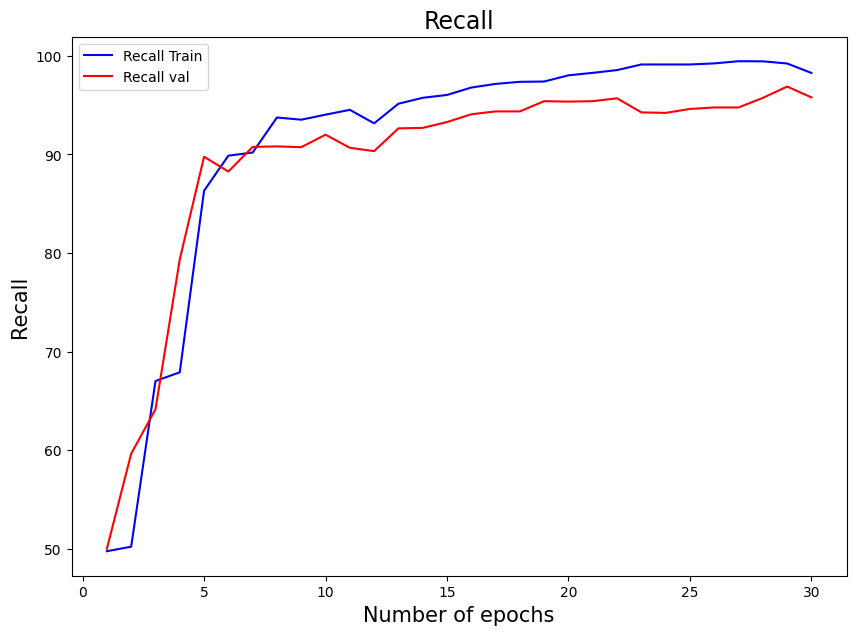

In [81]:
model_opt = model_NLP(300, 2, hidden_dim_opt, n_layers_opt, max_length, lr_opt, n_epochs_opt, n_batches_train, device, class_model_opt)
model_opt.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = True, graph = True)

### ii. Threshold

In [82]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [83]:
all_f1_t = []
all_recall_t = []
all_precision_t = []

all_threshold = []

for t in range(10, 90):

  threshold = t/100

  prob_val = model_opt.evaluate(X_val_c[0])
  y_pred_val = (prob_val > threshold)*1
  y_real_val = np.array(y_val)

  prob_test = model_opt.evaluate(X_test_c[0])
  y_pred_test = (prob_test > threshold)*1
  y_real_test = np.array(y_test)

  all_threshold.append(threshold)

  all_f1_t.append(round(f1_score(y_real_val, y_pred_val)*100, 2))
  all_recall_t.append(round(recall_score(y_real_val, y_pred_val)*100, 2))
  all_precision_t.append(round(precision_score(y_real_val, y_pred_val)*100, 2))

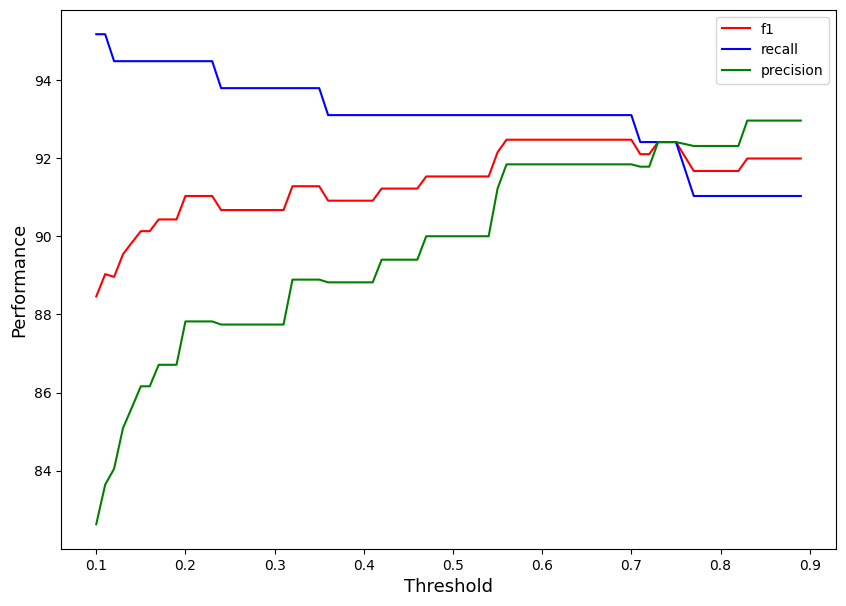

In [84]:
plt.figure(figsize = (10, 7))

plt.plot(all_threshold, all_f1_t, color = 'red', label = 'f1')
plt.plot(all_threshold, all_recall_t, color = 'blue', label = 'recall')
plt.plot(all_threshold, all_precision_t, color = 'green', label = 'precision')

plt.xlabel('Threshold', fontsize = 13)
plt.ylabel('Performance', fontsize = 13)

plt.legend()
plt.show()

In [85]:
threshold_opt = 0.5

In [86]:
prob_val = model_opt.evaluate(X_val_c[0])
y_pred_val = (prob_val > threshold_opt)*1
y_real_val = np.array(y_val)

prob_test = model_opt.evaluate(X_test_c[0])
y_pred_test = (prob_test > threshold_opt)*1
y_real_test = np.array(y_test)

In [87]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 93.1
Precision val: 90.0
F1 val: 91.53
Accuracy val: 97.76


In [88]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 93.55
Precision test: 91.77
F1 test: 92.65
Accuracy test: 97.94


### iii. Calibration

In [89]:
from sklearn.calibration import calibration_curve

In [90]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')

    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

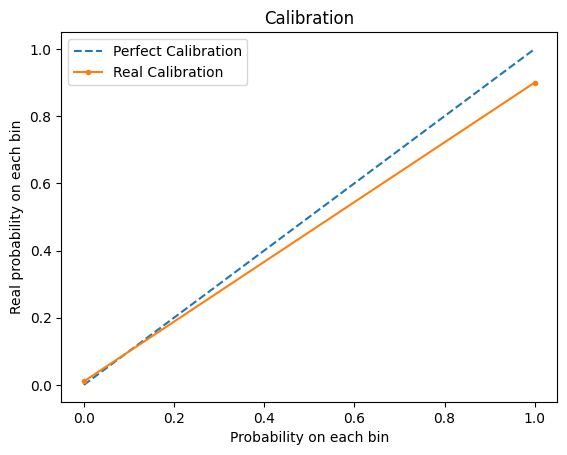

In [91]:
calibration(y_real_val, y_pred_val)

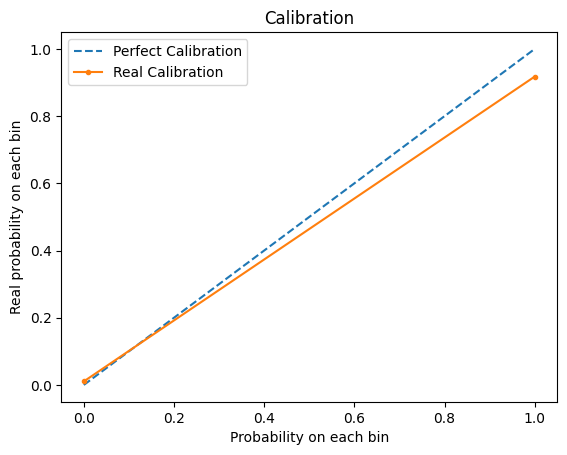

In [92]:
calibration(y_real_test, y_pred_test)

# 15. Evaluation two messages

In [93]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [94]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [95]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [96]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_length)

In [97]:
X_p_c[0] = X_p_c[0].to(device)

In [98]:
out_p = model_opt.evaluate(X_p_c[0])

In [99]:
round(out_p[0]*100, 4)

0.0063

In [100]:
round(out_p[1]*100, 4)

100.0

### Time of execution

In [101]:
end = time.time()
print_time_execution(start, end, 'Execute the notebook')

Execute the notebook it takes 0 hours, 7 mins and 26 segs.
